In [1]:
#%matplotlib inline
%time from hikyuu.interactive import *
use_draw_engine('matplotlib')

Initialize hikyuu_2.7.3_202601130334_RELEASE_macosx_arm64 ...
2026-01-13 15:09:12.043 [HKU-I] - current python version: 3.12.7 (main.cpp:74)


2026-01-13 15:09:13,598 [INFO] runing in interactive session [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:143) [hikyuu::hku_info]
2026-01-13 15:09:13,599 [INFO] running in jupyter [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:150) [hikyuu::hku_info]


2026-01-13 15:09:13.603 [HKU-I] - 插件路径: /Users/fasiondog/workspace/hku_plugin/hikyuu_plugin (StockManager.cpp:113)
2026-01-13 15:09:14.082 [HKU-I] - Using SQLITE3 BaseInfoDriver (BaseInfoDriver.cpp:57)
2026-01-13 15:09:14.095 [HKU-I] - 加载市场信息…… (StockManager.cpp:755)
2026-01-13 15:09:14.096 [HKU-I] - 加载证券类型信息…… (StockManager.cpp:773)
2026-01-13 15:09:14.096 [HKU-I] - 加载证券信息…… (StockManager.cpp:653)
2026-01-13 15:09:14.169 [HKU-I] - 加载权息数据…… (StockManager.cpp:791)
2026-01-13 15:09:14.339 [HKU-I] - 加载板块信息…… (StockManager.cpp:182)
2026-01-13 15:09:14.626 [HKU-I] - 加载K线数据…… (StockManager.cpp:186)
2026-01-13 15:09:14.627 [HKU-I] - 预加载 day K线数据至缓存 (最大数量: 100000)! (StockManager.cpp:237)
2026-01-13 15:09:14.627 [HKU-I] - 0.53 秒数据加载完毕. (StockManager.cpp:193)
CPU times: user 1.26 s, sys: 238 ms, total: 1.5 s
Wall time: 2.72 s


# 一、策略分析

## 原始描述

建仓条件：expma周线exp1跟exp2金叉向上使用使用 B=50% 的资金买入股票，建仓成功后，卖出条件才能起作用

卖出条件S1：expma日线exp1和exp2死叉向下时卖出持仓股 S=50%

买入条件B1：expma日线exp1和exp2金叉向上时买入股票数为S（卖出条件S1卖出股数）

S1和B1就这样循环

清仓条件为：expma周线exp1和exp2死叉时


## 策略分析

市场环境：无

系统有效性：周线EMA1（快线）和EMA2（慢线）金叉向上直到两者死叉，系统有效时建立初始仓位

信号指示器：
- 买入：日线EMA1（快线）和EMA2（慢线）金叉向上
- 卖出：日线EMA1（快线）和EMA2（慢线）死叉向下

止损/止盈：无

资金管理：
- 初次建仓：使用50%的资金
- 买入：初次建仓时持股数的50%
- 卖出：初次建仓时持股数的50%

盈利目标：无


# 二、实现系统部件

## 自定义系统有效性策略

In [2]:
def getNextWeekDateList(week):
    from datetime import timedelta
    py_week = week.datetime()
    next_week_start = py_week + timedelta(days = 7 - py_week.weekday())
    next_week_end = next_week_start + timedelta(days=5)
    return get_date_range(Datetime(next_week_start), Datetime(next_week_end))
#ds = getNextWeekDateList(Datetime(201801010000))
#for d in ds:
#    print(d)

In [3]:
def DEMO_CN(self):
    """ DIF > DEA 时，系统有效
    参数：
    fast_n：周线dif窗口
    slow_n: 周线dea窗口
    """
    k = self.to
    if (len(k) <= 10):
        return
    
    #-----------------------------
    # 周线        
    #-----------------------------
    week_q = Query(k[0].datetime, k[-1].datetime, ktype=Query.WEEK)
    week_k = k.get_stock().get_kdata(week_q)
    
    n1 = self.get_param("week_macd_n1")
    n2 = self.get_param("week_macd_n2")
    n3 = self.get_param("week_macd_n3")
    m = MACD(CLOSE(week_k), n1, n2, n3)
    fast = m.get_result(0)
    slow = m.get_result(1)

    x = fast > slow
    for i in range(x.discard, len(x)-1):
        if (x[i] >= 1.0):
            #需要被扩展到日线（必须是后一周）
            date_list = getNextWeekDateList(week_k[i].datetime)
            for d in date_list:
                self._add_valid(d)

## 自定义信号指示器

In [4]:
#这个例子不需要，已经有内建的SG_Cross函数可直接使用

## 自定义资金管理策略

In [5]:
class DEMO_MM(MoneyManagerBase):
    """
    初次建仓：使用50%的资金
    买入：初次建仓时持股数的50%
    卖出：初次建仓时持股数的50%
    """
    def __init__(self):
        super(DEMO_MM, self).__init__("MACD_MM")
        self.set_param("init_position", 0.5) #自定义初始仓位参数，占用资金百分比
        self.next_buy_num = 0
        
    def _reset(self):
        self.next_buy_num = 0
        #pass
        
    def _clone(self):
        mm = DEMO_MM()
        mm.next_buy_num = self.next_buy_num
        #return DEMO_MM()
    
    def _get_buy_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        cash = tm.current_cash
        
        #如果信号来源于系统有效条件，建立初始仓位
        if part_from == System.Part.CONDITION:
            #return int((cash * 0.5 // price // stk.atom) * stk.atom)  #MoneyManagerBase其实已经保证了买入是最小交易数的整数
            self.next_buy_num = 0 #清理掉上一周期建仓期间滚动买卖的股票数
            return int(cash * self.get_param("init_position") // price)
        
        #非初次建仓，买入同等数量
        return self.next_buy_num
    
    def _get_sell_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        position = tm.get_position(datetime, stk)
        current_num = int(position.number * 0.5)
        
        #记录第一次卖出时的股票数，以便下次以同等数量买入
        if self.next_buy_num == 0:
            self.next_buy_num = current_num 
            
        return current_num #返回类型必须是整数

# 三、构建并运行系统

## 修改设定公共参数

每个系统部件以及TradeManager都有自己的公共参数会影响系统运行，具体可以查看帮助及试验。

比如：这个例子当前使用系统有效条件进行初始建仓，那么必须设置系统公共参数cn_open_position为True。否则，没有建立初始仓位的话，后续没有卖出，不会有任何交易。

In [6]:
#System参数
#delay=True #(bool) : 是否延迟到下一个bar开盘时进行交易
#delay_use_current_price=True #(bool) : 延迟操作的情况下，是使用当前交易时bar的价格计算新的止损价/止赢价/目标价还是使用上次计算的结果
#max_delay_count=3 #(int) : 连续延迟交易请求的限制次数
#tp_monotonic=True #(bool) : 止赢单调递增
#tp_delay_n=3 #(int) : 止盈延迟开始的天数，即止盈策略判断从实际交易几天后开始生效
#ignore_sell_sg=False #(bool) : 忽略卖出信号，只使用止损/止赢等其他方式卖出
#ev_open_position=False #(bool): 是否使用市场环境判定进行初始建仓

cn_open_position=True #(bool): 是否使用系统有效性条件进行初始建仓

#MoneyManager公共参数
#auto-checkin=False #(bool) : 当账户现金不足以买入资金管理策略指示的买入数量时，自动向账户中补充存入（checkin）足够的现金。
#max-stock=20000 #(int) : 最大持有的证券种类数量（即持有几只股票，而非各个股票的持仓数）
#disable_ev_force_clean_position=False #(bool) : 禁用市场环境失效时强制清仓
#disable_cn_force_clean_position=False #(bool) : 禁用系统有效条件失效时强制清仓


## 设定私有参数及待测试标的

In [7]:
#账户参数
init_cash = 500000 #账户初始资金
init_date = '1990-1-1' #账户建立日期

#信号指示器参数
week_n1 = 12
week_n2 = 26
week_n3 = 9

#选定标的，及测试区间
stk = sm['sz000002']

#如果是同一级别K线，可以使用索引号，使用了不同级别的K线数据，建议还是使用日期作为参数
#另外，数据量太大的话，matplotlib绘图会比较慢
start_date = Datetime('2016-01-01')  
end_date = Datetime()

## 构建系统实例

In [8]:
#创建模拟交易账户进行回测，初始资金30万
my_tm = crtTM(date=Datetime(init_date), init_cash = init_cash)

#创建系统实例
my_sys = SYS_Simple()

my_sys.set_param("cn_open_position", cn_open_position)

my_sys.tm = my_tm
my_cn = crtCN(DEMO_CN, 
              {'week_macd_n1': week_n1, 'week_macd_n2': week_n2, 'week_macd_n3': week_n3}, 
                'DEMO_CN')  
my_sys.cn = my_cn
my_sys.sg = SG_Cross(EMA(C, n=week_n1), EMA(C, n=week_n2))
my_mm = DEMO_MM()
my_sys.mm = my_mm

## 运行系统

In [9]:
q = Query(start_date, end_date, ktype=Query.DAY)
my_sys.run(stk, q)

#将交易记录及持仓情况，保存在临时目录，可用Excel查看
#临时目录一般设置在数据所在目录下的 tmp 子目录
#如果打开了excel记录，再次运行系统前，记得先关闭excel文件，否则新的结果没法保存
my_tm.tocsv(sm.tmpdir())

# 四、查看资金曲线及绩效统计

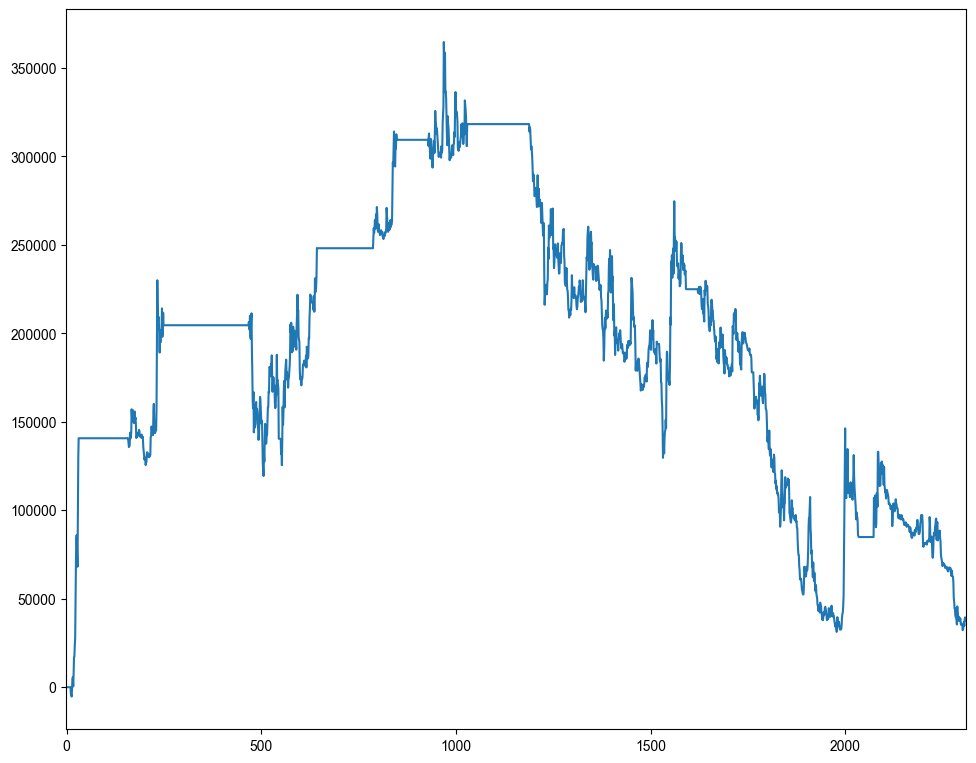

In [10]:
#绘制资金收益曲线
x = my_tm.get_profit_curve(stk.get_datetime_list(q), Query.DAY)
#x = my_tm.getFundsCurve(stk.getDatetimeList(q), KQuery.DAY) #资金净值曲线
PRICELIST(x).plot()

In [11]:
#回测统计
per = my_tm.get_performance()
print(per.to_df())

                         name          value
0                帐户初始金额  500000.000000
1                累计投入本金  500000.000000
2                累计投入资产       0.000000
3                累计借入现金       0.000000
4                累计借入资产       0.000000
5                    累计红利   73014.720000
6                    现金余额  433765.210000
7              未平仓头寸净值  104007.440000
8                  当前总资产  537772.650000
9            已平仓交易总成本       0.000000
10           已平仓净利润总额   84859.220000
11  单笔交易最大占用现金比例%      49.989970
12      交易平均占用现金比例%      40.609108
13          未平仓帐户收益率%       7.554530
14          已平仓帐户收益率%      16.971844
15          帐户年复合收益率%       0.769889
16          帐户平均年收益率%       0.795558
17           赢利交易赢利总额  413375.710000
18           亏损交易亏损总额 -328516.490000
19             已平仓交易总数      13.000000
20                 赢利交易数       7.000000
21                 亏损交易数       6.000000
22              赢利交易比例%      53.846154
23                 赢利期望值    6527.630000
24           赢利交易平均赢利   59053.670000
25

# 五、或许想看下图形

<Axes: title={'center': '账户(SYS) 累积收益率'}>

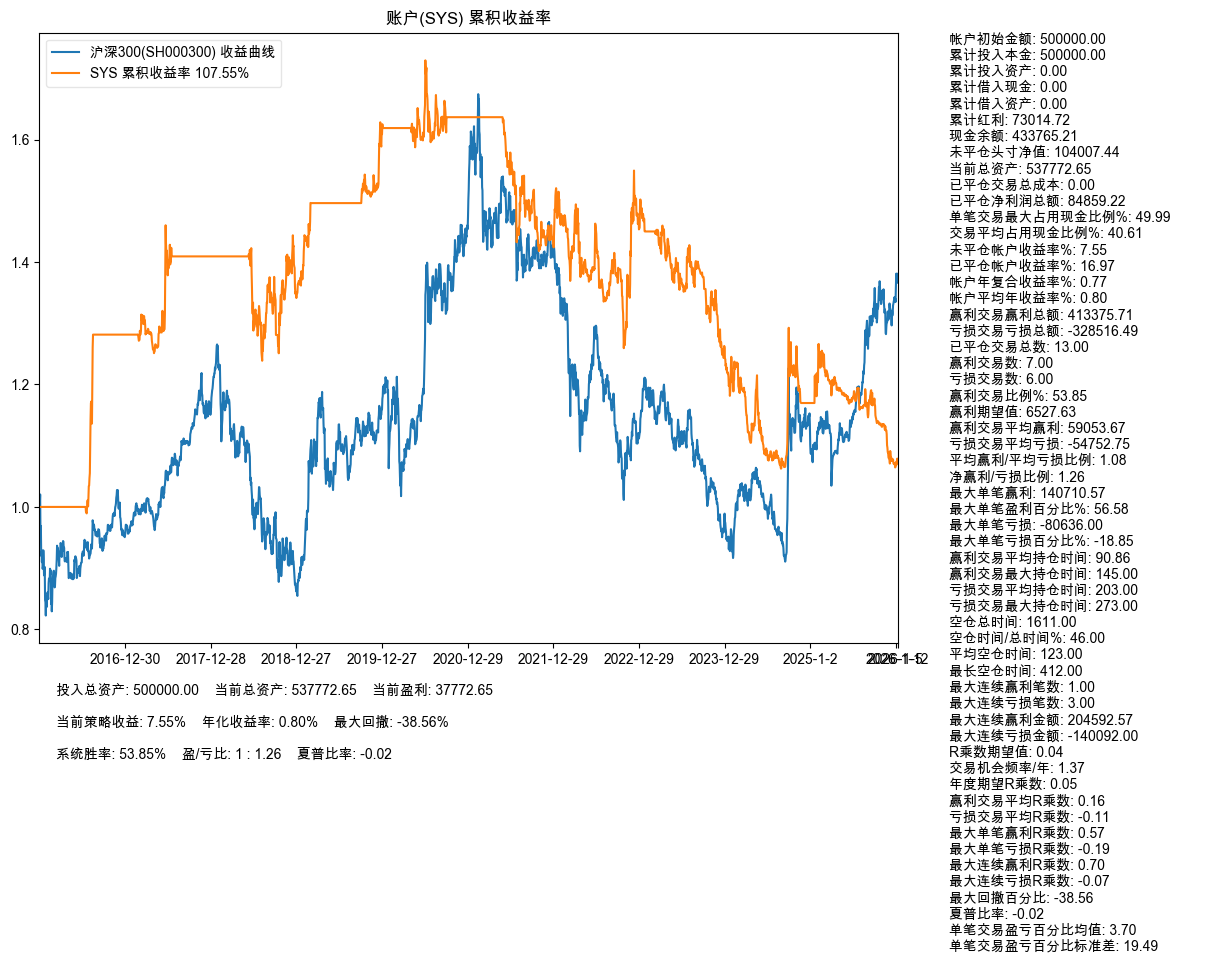

In [12]:
my_sys.performance()

# 六、或许想看看所有股票的情况

In [13]:
import pandas as pd
def calTotal(blk, q):
    per = Performance()
    s_name = []
    s_code = []
    x = []
    for stk in blk:
        my_sys.run(stk, q)
        per.statistics(my_tm, Datetime.now())
        s_name.append(stk.name)
        s_code.append(stk.market_code)
        x.append(per["当前总资产"])
    return pd.DataFrame({'代码': s_code, '股票': s_name, '当前总资产': x})

%time data = calTotal(blocka, q)

2026-01-13 15:09:53.458 [HKU-E] - 2021-11-12 00:00:00 SH600519 Sell number(50) must be >= minTradeNumber(100)! (TradeManager.cpp:893)
2026-01-13 15:09:53.459 [HKU-E] - 2022-04-27 00:00:00 SH600519 Sell number(50) must be >= minTradeNumber(100)! (TradeManager.cpp:893)
2026-01-13 15:09:53.459 [HKU-E] - 2022-05-19 00:00:00 SH600519 Sell number(50) must be >= minTradeNumber(100)! (TradeManager.cpp:893)
2026-01-13 15:09:53.459 [HKU-E] - 2022-05-25 00:00:00 SH600519 Sell number(50) must be >= minTradeNumber(100)! (TradeManager.cpp:893)
2026-01-13 15:09:53.459 [HKU-E] - 2023-03-08 00:00:00 SH600519 Sell number(50) must be >= minTradeNumber(100)! (TradeManager.cpp:893)
2026-01-13 15:09:53.460 [HKU-E] - 2023-07-11 00:00:00 SH600519 Sell number(50) must be >= minTradeNumber(100)! (TradeManager.cpp:893)
CPU times: user 1min 9s, sys: 4.42 s, total: 1min 14s
Wall time: 1min 13s


In [14]:
#保存到CSV文件
#data.to_csv(sm.tmpdir() + '/统计.csv')
data[:10]

,代码,股票,当前总资产
0,SH601003,柳钢股份,518854.76
1,BJ920837,华原股份,1133938.11
2,SH603180,金牌家居,455087.48
3,SZ000548,湖南投资,571510.35
4,SH600159,大龙地产,787702.00
5,SZ002099,海翔药业,418449.82
6,SH600732,爱旭股份,1291820.16
7,SH603127,昭衍新药,480300.63
8,SZ002953,日丰股份,757590.87
9,SH603758,秦安股份,581266.37
